In [1]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [2]:
# Determine important landmarks for squat
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Generate all columns of the data frame

landmarks = ["label"] # Label column

for lm in IMPORTANT_LMS:
    landmarks += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [3]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)
    

def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Write all the columns to a file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(landmarks)

        
def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)


def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 4160 
Number of columns: 37

Labels: 
down    2127
up      2033
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


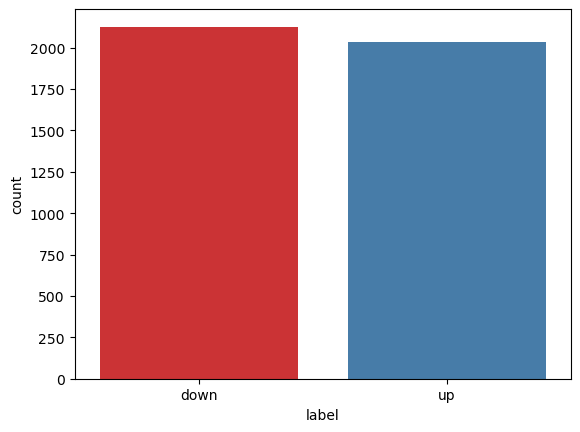

In [4]:
# Brief describe of the dataset
df = describe_dataset("./train.csv")
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "down", "label"] = 0
df.loc[df["label"] == "up", "label"] = 1

In [5]:
# Extract features and class
X = df.drop("label", axis=1) # features
y = df["label"].astype("int")

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [6]:
# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

3319    1
2621    0
3820    1
Name: label, dtype: int32

In [7]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])


,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,LR,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
1,SVC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
2,KNN,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
3,SGDC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
4,RF,"[0.998, 0.998]",0.997596,"[0.998, 0.998]","[0.998, 0.998]","[[426, 1], [1, 404]]"
5,DTC,"[0.995, 0.998]",0.996394,"[0.998, 0.995]","[0.996, 0.996]","[[426, 1], [2, 403]]"
6,NB,"[0.986, 1.0]",0.992788,"[1.0, 0.985]","[0.993, 0.993]","[[427, 0], [6, 399]]"


In [8]:
test_df = describe_dataset("./test.csv")
test_df.loc[test_df["label"] == "down", "label"] = 0
test_df.loc[test_df["label"] == "up", "label"] = 1

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 853 
Number of columns: 37

Labels: 
down    430
up      423
Name: label, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: float64)


In [9]:
testset_final_results = []

for name, model in models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])
    testset_final_results.append(( name,  (p_score), a_score, (r_score), (f1_score_result), cm ))


testset_final_results.sort(key=lambda k: k[4], reverse=True)
eval_df = pd.DataFrame(testset_final_results, columns=["Model", "Precision score", "Accuracy score", "Recall score", "F1 score", "Confusion Matrix"])
eval_df = eval_df.sort_values(by=['F1 score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision score,Accuracy score,Recall score,F1 score,Confusion Matrix
0,SGDC,0.995321,0.995311,0.995311,0.995311,"[[429, 1], [3, 420]]"
1,LR,0.994141,0.994138,0.994138,0.994138,"[[428, 2], [3, 420]]"
2,KNN,0.985207,0.984760,0.984760,0.984754,"[[430, 0], [13, 410]]"
3,SVC,0.977595,0.976553,0.976553,0.976536,"[[430, 0], [20, 403]]"
4,DTC,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"
5,NB,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"
6,RF,0.254120,0.504103,0.504103,0.337902,"[[430, 0], [423, 0]]"


In [10]:
with open("./model/sklearn_models.pkl", "wb") as f:
    pickle.dump(models, f)

In [11]:
with open("./model/LR_model.pkl", "wb") as f:
    pickle.dump(models["LR"], f)